In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset
import gymnasium as gym

from astropy.io import fits
from datetime import datetime
import json
import fitsio
import pandas as pd
import time
import pickle

%reload_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../survey_ops/utils')
from ephemerides import get_source_ra_dec, equatorial_to_topographic, topographic_to_equatorial
from geometry import angular_separation
from units import *

sys.path.append('../survey_ops/src')
import environments
from offline_dataset import TelescopeDatasetv0
from agents import Agent
from algorithms import DDQN, BehaviorCloning
from offline_dataset import OfflineDataset

In [3]:
from pytorch_utils import seed_everything
seed_everything(10)

# Load and cut data from fits file, save as .json

In [4]:
data_json_fn = '../data/data.json'
data_fits_fn = '../data/decam-exposures-20251107.fits.gz'

try:
    # --- Load json df ---- #
    df = pd.read_json(data_json_fn)
    print('Loaded data from json')
except:
    # --- Load fits ---- #
    print(data_json_fn, 'DNE. Loading and processing data from fits.')
    d = fitsio.read('../data/decam-exposures-20251107.fits.gz')
    sel = (d['propid'] == '2012B-0001') & (d['exptime'] > 40) & (d['exptime'] < 100) & (~np.isnan(d['teff']))
    selected_d = d[sel]
    column_names = selected_d.dtype.names
    df = pd.DataFrame(selected_d, columns=column_names)
    print(df['datetime'].dtype)
    
    # mask = np.array([False if 'None' in dt else True for dt in subs_data['datetime']])
    # subs_data = {key: subs_data[key][mask] for key in subs_data.keys()}
    
    df.to_json(data_json_fn, indent=2)
    df = pd.read_json(data_json_fn)
    

Loaded data from json


# Instantiate the offline dataset choosing number of bins for (az,el)

## You can get the data/transitions for the entire dataset in the dataframe

In [5]:
num_bins_1d = 19

dataset = OfflineDataset(
    df, 
    num_bins_1d=num_bins_1d, 
    normalize_state=True,
) #specific_years=[2013,2014])

## You can also specify years, months, days, and filters to get a smaller subset of transitions

In [6]:
num_bins_1d = 19
dataset = OfflineDataset(
    df, 
    num_bins_1d=19, 
    normalize_state=True,
    specific_years=[2018, 2019],
    specific_months=[12],
    specific_days=np.arange(10),
    specific_filters=['r', 'g']
)

In [7]:
dataset._df

,expnum,ra,dec,exptime,filter,propid,program,teff,fwhm,az,zd,ha,airmass,qc_fwhm,qc_cloud,qc_sky,qc_teff,timestamp
datetime,,,,,,,,,,,,,,,,,,
2018-12-01 00:47:38,798167,18.994829,-33.488750,90,r,2012B-0001,survey,1.05,0.82,116.242401,7.920000,-8.279625,1.01,0.82,-0.03,0.24,1.05,1543625258
2018-12-01 00:49:36,798168,18.994829,-33.488777,90,g,2012B-0001,survey,1.07,0.87,117.236198,7.590000,-7.857542,1.01,0.87,-0.04,0.21,1.07,1543625376
2018-12-01 00:51:53,798169,17.122995,-34.503277,90,r,2012B-0001,survey,1.06,0.85,133.462006,6.330000,-5.340250,1.01,0.85,-0.03,0.15,1.06,1543625513
2018-12-01 00:53:53,798170,17.123158,-34.503304,90,g,2012B-0001,survey,1.26,0.87,135.581696,6.080000,-4.922500,1.01,0.87,-0.02,0.03,1.26,1543625633
2018-12-01 00:55:51,798171,19.150171,-35.517834,90,r,2012B-0001,survey,1.43,0.75,135.129105,7.650000,-6.387292,1.01,0.75,-0.02,0.09,1.43,1543625751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-09 03:56:19,801178,87.057045,-59.865219,90,g,2012B-0001,survey,0.87,1.10,160.421494,32.959999,-21.035917,1.19,1.10,-0.01,-0.07,0.87,1544327779
2018-12-09 04:02:49,801181,89.869949,-58.850525,90,g,2012B-0001,survey,0.90,1.09,158.409103,32.509998,-22.224083,1.19,1.09,-0.03,-0.09,0.90,1544328169
2018-12-09 04:06:51,801183,92.524452,-57.836166,90,g,2012B-0001,survey,0.85,1.12,155.901001,32.310001,-23.955708,1.18,1.12,-0.02,-0.09,0.85,1544328411


In [8]:
for items in (dataset._df.index.year, dataset._df.index.month, dataset._df.index.day, dataset._df['filter']):
    print(np.unique(items))

[2018]
[12]
[1 2 3 4 5 6 7 8 9]
['g' 'r']


# Configure model, data selection, and training setup

In [9]:
SEED = 10
seed_everything(SEED)
torch.set_default_dtype(torch.float32)
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "cpu"   
)

In [10]:
num_bins_1d = 19
dataset = OfflineDataset(
    df, 
    num_bins_1d=19, 
    normalize_state=True,
    specific_years=[2018],
    specific_months=[12],
    specific_days=np.arange(2),
    specific_filters=['g']
)

In [11]:
batch_size = 32
num_workers = 4
pin_memory = True if device == 'cuda' else False
trainloader = dataset.get_dataloader(batch_size, num_workers = num_workers, pin_memory = pin_memory)


In [25]:
"""Algorithm and Train setup"""

alg_config = {
    'obs_dim': dataset.obs_dim,
    'num_actions': dataset.num_actions,
    'hidden_dim': 64,
    'device': device,
    'lr': 5e-3,
    'loss_fxn': None, #torch.nn.cross_entropy,
    # 'use_double': True,
}
alg = BehaviorCloning(**alg_config)

fit_config = {
    'num_epochs' : 100,
    'batch_size': batch_size,
    # 'learning_start': 
    }

env_name = 'TelescopeEnv-v0'

def create_exp_name(alg, env_name, dataset, fit_config, alg_config):
    exp_name = f"{alg.name}"
    exp_name += f"-{env_name}"
    exp_name += f"-n_nights={dataset.n_nights}"
    # config_prefix += f"-use_double={alg_config['use_double']}"
    exp_name += f"-num_epochs={fit_config['num_epochs']}"
    exp_name += f"-batch_size={fit_config['batch_size']}"
    exp_name += f"-lr={alg_config['lr']}"
    return exp_name

exp_name = create_exp_name(alg, env_name, dataset, fit_config, alg_config)

outdir = f'../results/{exp_name}/'
if not os.path.exists(outdir):
    os.makedirs(outdir)
fig_outdir = outdir + 'figures/'
if not os.path.exists(fig_outdir):
    os.makedirs(fig_outdir)

agent_config = {
    'algorithm': alg,
    'normalize_obs': dataset.normalize_state,
    'outdir': outdir
    }

agent = Agent(**agent_config)



# Visualize dataset in (az, el) and binning sizes

Text(0.5, 0.98, 'Num bins=19x19=361')

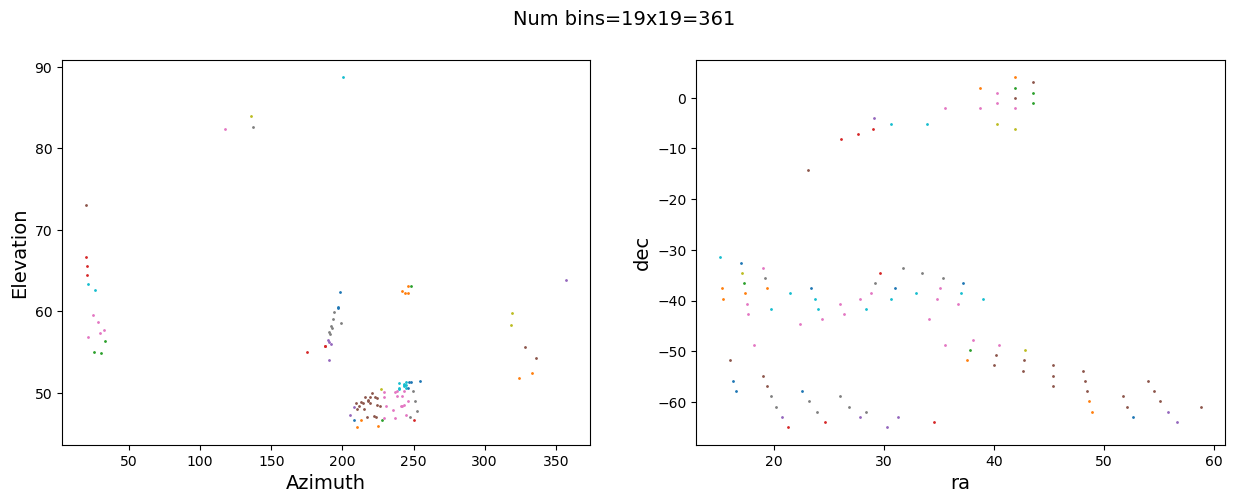

In [26]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
for bin_id in dataset.id2azel.keys():
    field_ids = np.array(dataset.id2azel[bin_id])
    
    axs[0].scatter(field_ids[:, 0], field_ids[:, 1], label='bin' + str(bin_id), s=1)
# plt.legend()
axs[0].set_xlabel('Azimuth', fontsize=14)
axs[0].set_ylabel('Elevation', fontsize=14)

for bin_id in dataset.id2radec.keys():
    field_ids = np.array(dataset.id2radec[bin_id])
    
    axs[1].scatter(field_ids[:, 0], field_ids[:, 1], label='bin' + str(bin_id), s=1)
# plt.legend()
axs[1].set_xlabel('ra', fontsize=14)
axs[1].set_ylabel('dec', fontsize=14)

fig.suptitle(f'Num bins={num_bins_1d}x{num_bins_1d}={dataset.num_actions}', fontsize=14)


# Train

In [ ]:
start_time = time.time()
"""Train"""
agent.fit(
    dataloader=trainloader,
    **fit_config
    )
end_time = time.time()
train_time = end_time - start_time
print(train_time)

  0%|▏                                      | 44/10800 [00:00<00:42, 252.15it/s]

Train step 0: Accuracy = 0.062, Loss = 5.8762


  2%|▌                                     | 171/10800 [00:00<00:27, 382.53it/s]

Train step 100: Accuracy = 0.469, Loss = 1.4414


  2%|▉                                     | 253/10800 [00:00<00:26, 394.31it/s]

Train step 200: Accuracy = 0.625, Loss = 0.9580


  4%|█▎                                    | 380/10800 [00:01<00:25, 411.10it/s]

Train step 300: Accuracy = 0.625, Loss = 0.9661


  4%|█▋                                    | 464/10800 [00:01<00:24, 414.83it/s]

Train step 400: Accuracy = 0.688, Loss = 0.6526


  5%|█▉                                    | 552/10800 [00:01<00:24, 425.53it/s]

Train step 500: Accuracy = 0.750, Loss = 0.7234


  6%|██▍                                   | 681/10800 [00:01<00:24, 420.05it/s]

Train step 600: Accuracy = 0.750, Loss = 0.8135


  7%|██▋                                   | 767/10800 [00:01<00:23, 419.93it/s]

Train step 700: Accuracy = 0.812, Loss = 0.5621


  8%|██▉                                   | 852/10800 [00:02<00:24, 411.79it/s]

Train step 800: Accuracy = 0.719, Loss = 0.5503


  9%|███▍                                  | 979/10800 [00:02<00:23, 415.66it/s]

Train step 900: Accuracy = 0.781, Loss = 0.5940


 10%|███▋                                 | 1067/10800 [00:02<00:22, 423.20it/s]

Train step 1000: Accuracy = 0.844, Loss = 0.5583


 11%|███▉                                 | 1155/10800 [00:02<00:22, 426.23it/s]

Train step 1100: Accuracy = 0.688, Loss = 0.4557


 12%|████▎                                | 1243/10800 [00:03<00:22, 423.69it/s]

Train step 1200: Accuracy = 0.719, Loss = 0.3968


 13%|████▋                                | 1373/10800 [00:03<00:22, 424.20it/s]

Train step 1300: Accuracy = 0.812, Loss = 0.5883


 14%|████▉                                | 1458/10800 [00:03<00:22, 417.21it/s]

Train step 1400: Accuracy = 0.719, Loss = 0.3151


 14%|█████▎                               | 1542/10800 [00:03<00:22, 404.85it/s]

Train step 1500: Accuracy = 0.812, Loss = 0.4486


 15%|█████▋                               | 1670/10800 [00:04<00:22, 407.81it/s]

Train step 1600: Accuracy = 0.750, Loss = 0.4376


 16%|██████                               | 1754/10800 [00:04<00:22, 409.27it/s]

Train step 1700: Accuracy = 0.750, Loss = 0.3624


 17%|██████▍                              | 1880/10800 [00:04<00:21, 409.35it/s]

Train step 1800: Accuracy = 0.906, Loss = 0.4091


 18%|██████▋                              | 1962/10800 [00:04<00:21, 404.67it/s]

Train step 1900: Accuracy = 0.875, Loss = 0.3264


 19%|███████                              | 2045/10800 [00:05<00:21, 400.70it/s]

Train step 2000: Accuracy = 0.750, Loss = 0.3301


 20%|███████▍                             | 2172/10800 [00:05<00:20, 414.90it/s]

Train step 2100: Accuracy = 0.906, Loss = 0.2631


 21%|███████▋                             | 2259/10800 [00:05<00:20, 423.08it/s]

Train step 2200: Accuracy = 0.906, Loss = 0.1433


 22%|████████                             | 2345/10800 [00:05<00:19, 422.81it/s]

Train step 2300: Accuracy = 0.812, Loss = 0.2440


 23%|████████▍                            | 2474/10800 [00:06<00:19, 422.60it/s]

Train step 2400: Accuracy = 0.938, Loss = 0.1874


 24%|████████▊                            | 2559/10800 [00:06<00:20, 411.18it/s]

Train step 2500: Accuracy = 0.844, Loss = 0.2207


 24%|█████████                            | 2643/10800 [00:06<00:19, 409.07it/s]

Train step 2600: Accuracy = 0.938, Loss = 0.5649


 26%|█████████▍                           | 2770/10800 [00:06<00:19, 409.25it/s]

Train step 2700: Accuracy = 0.875, Loss = 0.4815


 26%|█████████▊                           | 2854/10800 [00:06<00:19, 410.94it/s]

Train step 2800: Accuracy = 0.969, Loss = 0.2678


 28%|██████████▏                          | 2983/10800 [00:07<00:18, 418.12it/s]

Train step 2900: Accuracy = 0.812, Loss = 0.2589


 28%|██████████▌                          | 3068/10800 [00:07<00:18, 417.26it/s]

Train step 3000: Accuracy = 0.969, Loss = 0.2125


 29%|██████████▊                          | 3151/10800 [00:07<00:18, 409.30it/s]

Train step 3100: Accuracy = 0.844, Loss = 0.2087


 30%|███████████▏                         | 3278/10800 [00:08<00:18, 414.43it/s]

Train step 3200: Accuracy = 0.906, Loss = 0.1608


 31%|███████████▌                         | 3362/10800 [00:08<00:18, 408.20it/s]

Train step 3300: Accuracy = 1.000, Loss = 0.1777


 32%|███████████▊                         | 3444/10800 [00:08<00:18, 397.09it/s]

Train step 3400: Accuracy = 0.906, Loss = 0.2470


 33%|████████████▏                        | 3565/10800 [00:08<00:18, 393.65it/s]

Train step 3500: Accuracy = 0.969, Loss = 0.1942


 34%|████████████▍                        | 3646/10800 [00:08<00:18, 395.85it/s]

Train step 3600: Accuracy = 0.938, Loss = 0.1594


 35%|████████████▉                        | 3767/10800 [00:09<00:17, 396.89it/s]

Train step 3700: Accuracy = 0.969, Loss = 0.2068


 36%|█████████████▏                       | 3848/10800 [00:09<00:17, 392.14it/s]

Train step 3800: Accuracy = 0.969, Loss = 0.1546


 37%|█████████████▌                       | 3972/10800 [00:09<00:17, 398.12it/s]

Train step 3900: Accuracy = 0.906, Loss = 0.0760


 38%|█████████████▉                       | 4053/10800 [00:09<00:17, 393.96it/s]

Train step 4000: Accuracy = 0.938, Loss = 0.0867


 39%|██████████████▎                      | 4174/10800 [00:10<00:16, 392.35it/s]

Train step 4100: Accuracy = 0.875, Loss = 0.0821


 39%|██████████████▌                      | 4256/10800 [00:10<00:16, 397.26it/s]

Train step 4200: Accuracy = 0.906, Loss = 0.0776


 41%|███████████████                      | 4380/10800 [00:10<00:16, 397.41it/s]

Train step 4300: Accuracy = 0.906, Loss = 0.3034


 41%|███████████████▎                     | 4460/10800 [00:11<00:15, 396.40it/s]

Train step 4400: Accuracy = 0.969, Loss = 0.2549


 42%|███████████████▋                     | 4583/10800 [00:11<00:15, 402.12it/s]

Train step 4500: Accuracy = 0.938, Loss = 0.0855


 43%|███████████████▉                     | 4667/10800 [00:11<00:15, 407.72it/s]

Train step 4600: Accuracy = 0.906, Loss = 0.1510


 44%|████████████████▎                    | 4749/10800 [00:11<00:15, 401.00it/s]

Train step 4700: Accuracy = 1.000, Loss = 0.0744


 45%|████████████████▋                    | 4873/10800 [00:12<00:14, 404.15it/s]

Train step 4800: Accuracy = 1.000, Loss = 0.0283


 46%|████████████████▉                    | 4954/10800 [00:12<00:14, 391.82it/s]

Train step 4900: Accuracy = 1.000, Loss = 0.0437


 47%|█████████████████▍                   | 5075/10800 [00:12<00:14, 395.08it/s]

Train step 5000: Accuracy = 0.969, Loss = 0.1091


 48%|█████████████████▋                   | 5157/10800 [00:12<00:14, 399.72it/s]

Train step 5100: Accuracy = 0.969, Loss = 0.0865


 49%|██████████████████                   | 5283/10800 [00:13<00:13, 409.13it/s]

Train step 5200: Accuracy = 0.969, Loss = 0.1069


 50%|██████████████████▍                  | 5365/10800 [00:13<00:13, 402.08it/s]

Train step 5300: Accuracy = 0.969, Loss = 0.0513


 50%|██████████████████▋                  | 5449/10800 [00:13<00:13, 402.59it/s]

Train step 5400: Accuracy = 1.000, Loss = 0.0476


 52%|███████████████████                  | 5571/10800 [00:13<00:13, 390.17it/s]

Train step 5500: Accuracy = 0.938, Loss = 0.0443


 52%|███████████████████▎                 | 5652/10800 [00:14<00:13, 390.37it/s]

Train step 5600: Accuracy = 0.969, Loss = 0.0473


 54%|███████████████████▊                 | 5778/10800 [00:14<00:12, 404.55it/s]

Train step 5700: Accuracy = 0.938, Loss = 0.0892


 54%|████████████████████                 | 5860/10800 [00:14<00:12, 402.86it/s]

Train step 5800: Accuracy = 0.969, Loss = 0.1160


 55%|████████████████████▎                | 5941/10800 [00:14<00:12, 389.92it/s]

Train step 5900: Accuracy = 1.000, Loss = 0.0505


 56%|████████████████████▊                | 6063/10800 [00:15<00:12, 393.87it/s]

Train step 6000: Accuracy = 1.000, Loss = 0.0284


 57%|█████████████████████                | 6144/10800 [00:15<00:11, 392.25it/s]

Train step 6100: Accuracy = 0.938, Loss = 0.0982


 58%|█████████████████████▍               | 6267/10800 [00:15<00:11, 397.00it/s]

Train step 6200: Accuracy = 1.000, Loss = 0.0202


 59%|█████████████████████▋               | 6347/10800 [00:15<00:11, 389.94it/s]

Train step 6300: Accuracy = 0.969, Loss = 0.0824


 60%|██████████████████████▏              | 6466/10800 [00:16<00:11, 390.51it/s]

Train step 6400: Accuracy = 1.000, Loss = 0.3027


 61%|██████████████████████▍              | 6547/10800 [00:16<00:10, 392.65it/s]

Train step 6500: Accuracy = 0.969, Loss = 0.0140


 62%|██████████████████████▊              | 6668/10800 [00:16<00:10, 390.40it/s]

Train step 6600: Accuracy = 0.969, Loss = 0.0119


 63%|███████████████████████▏             | 6751/10800 [00:16<00:10, 399.14it/s]

Train step 6700: Accuracy = 1.000, Loss = 0.0215


 64%|███████████████████████▌             | 6876/10800 [00:17<00:09, 404.93it/s]

Train step 6800: Accuracy = 0.906, Loss = 0.0682


 64%|███████████████████████▊             | 6958/10800 [00:17<00:09, 403.10it/s]

Train step 6900: Accuracy = 0.969, Loss = 0.2760


 66%|████████████████████████▎            | 7081/10800 [00:17<00:09, 396.72it/s]

Train step 7000: Accuracy = 0.969, Loss = 0.1471


 66%|████████████████████████▍            | 7121/10800 [00:17<00:09, 391.98it/s]

In [20]:
outdir

'../results/None/'

In [15]:
with open(outdir + 'train_metrics.pkl', 'rb') as handle:
    train_metrics = pickle.load(handle)

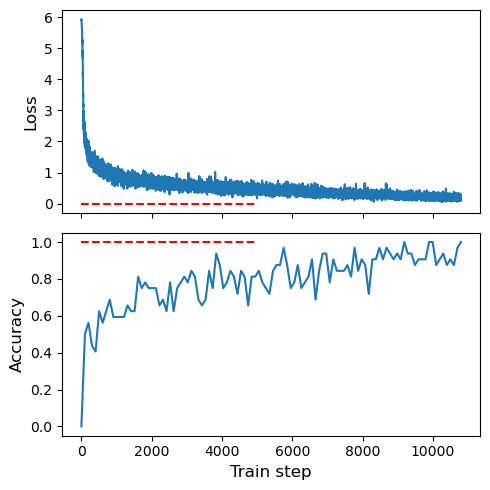

In [16]:
fig, axs = plt.subplots(2, sharex=True, figsize=(5, 5))
axs[0].plot(train_metrics['loss_history'])
axs[0].hlines(y=0, xmin=0, xmax=5000, color='red', linestyle='--')
axs[0].set_ylabel('Loss', fontsize=12)
axs[1].plot(np.linspace(0, len(train_metrics['loss_history']), len(train_metrics['test_acc_history'])), train_metrics['test_acc_history'])
axs[1].hlines(y=1, xmin=0, xmax=5000, color='red', linestyle='--')
axs[1].set_xlabel('Train step', fontsize=12)
axs[1].set_ylabel('Accuracy', fontsize=12)
axs[1].set_xlabel('Train step', fontsize=12)
fig.tight_layout()
fig.savefig(fig_outdir + 'train_history.png')

# Evaluate

In [ ]:
from environments import TelescopeEnv_v0

env_name = 'TelescopeEnv-v0'

gym.register(
    id=f"gymnasium_env/{env_name}",
    entry_point=TelescopeEnv_v0,
    max_episode_steps=300,  # Prevent infinite episodes. Here just set to 300 even though episode will terminate when stepping to last element of sequence
)

# for eval step only
env_config = {
    'id': f"gymnasium_env/{env_name}",
    'dataset': dataset
}


env = gym.make(**env_config)
# Create multiple environments for parallel training
# vec_env = gym.make_vec("gymnasium_env/SimpleTel-v0", num_envs=5, vectorization_mode='sync', Nf=Nf, target_sequence=true_sequence, nv_max=nv_max)

from gymnasium.utils.env_checker import check_env

# This will catch many common issues
try:
    check_env(env.unwrapped)
    print("Environment passes all checks!")
except Exception as e:
    print(f"Environment has issues: {e}")

In [22]:
agent.evaluate(env=env, num_episodes=1)
with open(outdir + 'eval_metrics.pkl', 'rb') as handle:
    eval_metrics = pickle.load(handle)

100%|██████████| 1/1 [00:00<00:00, 90.72it/s]

terminated at 58
eval_metrics.pkl saved in ../results/None/


/tmp/ipykernel_17254/76053858.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend()


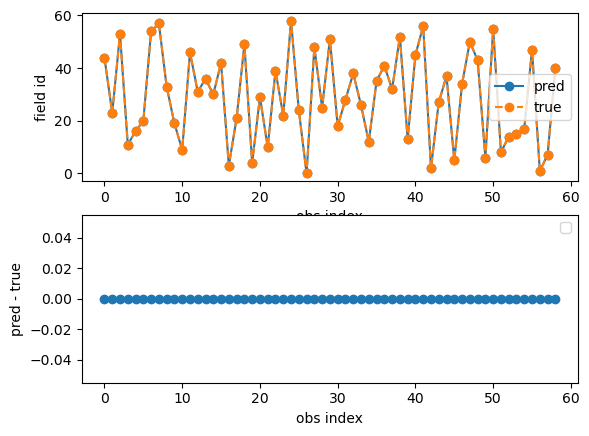

In [23]:
target_sequence = dataset._schedule_field_ids[0]
eval_sequence = eval_metrics['observations']['ep-0'][:, 0]

fig, axs = plt.subplots(2)
axs[0].plot(eval_sequence, marker='o', label='pred')
axs[0].plot(target_sequence, marker='o', linestyle='dashed', label='true')
axs[0].legend()
axs[0].set_xlabel('obs index')
axs[0].set_ylabel('field id')

axs[1].plot(eval_sequence - target_sequence, marker='o')
axs[1].legend()
axs[1].set_xlabel('obs index')
axs[1].set_ylabel('pred - true')


fig.savefig(outdir + 'learned_sequence.png')